<font size="6">Discovering Latent States in Fractionally Differentiated Series</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and variance</b> parameters allowing computation of a likelihood function for the point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\large D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states' mean/variances factorize, 

$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$


In [144]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

Set num_components to a very high number since the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [145]:
num_components = 99

Get the data. This is a small sample of some intraday (minute frequency) data. 

In [146]:
tlt = pd.read_csv('./data/TLT_sample.csv')

<font size="5">Fractional Differentiation</font>

Formatting the training data and viewing how auto-correlation slowly decays over successive lags. There is only training data and no test data in this exercise (it is a purely descriptive exercise). Fractional differentiation as described by Marcos Lopez de Prado, to address the stationarity/memory trade off. 

Reference: https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482109

In [147]:
%pip install numpy-fracdiff

Note: you may need to restart the kernel to use updated packages.


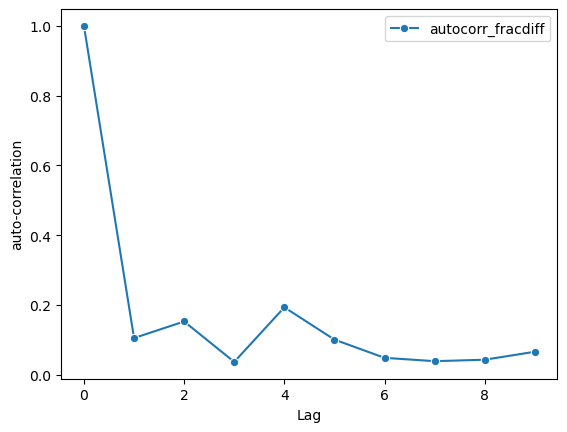

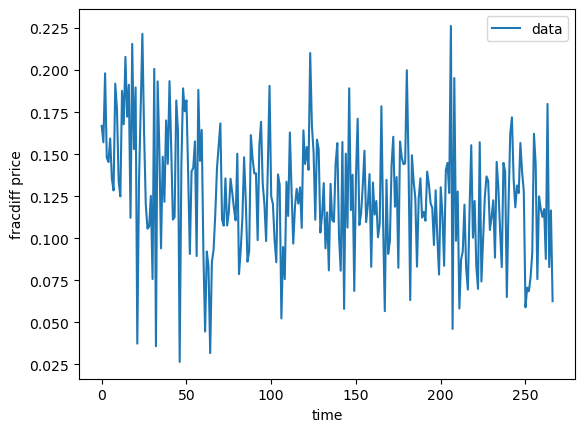

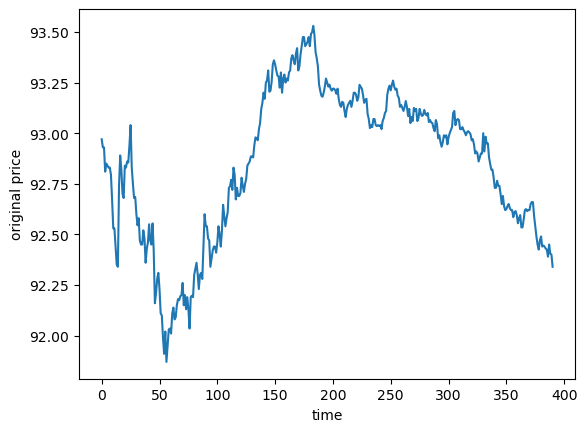

In [155]:
from numpy_fracdiff.fracdiff_fn import fracdiff
import scipy.stats as stats

fn = lambda x: fracdiff(x.values, order=frac_order)
frac_order = 0.9

frac_df = pd.DataFrame()
frac_df['data'] = fn(tlt['marketClose'])
frac_df = frac_df.dropna().reset_index().drop(columns=['index'])

decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(frac_df['data'], range(0, 10)), label='autocorr_fracdiff', marker='o') 
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

sns.lineplot(data=frac_df)
plt.xlabel('time')
plt.ylabel('fracdiff price')
plt.show()

sns.lineplot(data=tlt['marketClose'])
plt.xlabel('time')
plt.ylabel('original price')
plt.show()

Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the initial state that diffuses away over time, states[0]. 

In [166]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process',
                                          n_init=1, 
                                          max_iter=10)

In [167]:
dpgmm_model.fit(frac_df)
states = dpgmm_model.predict(frac_df)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

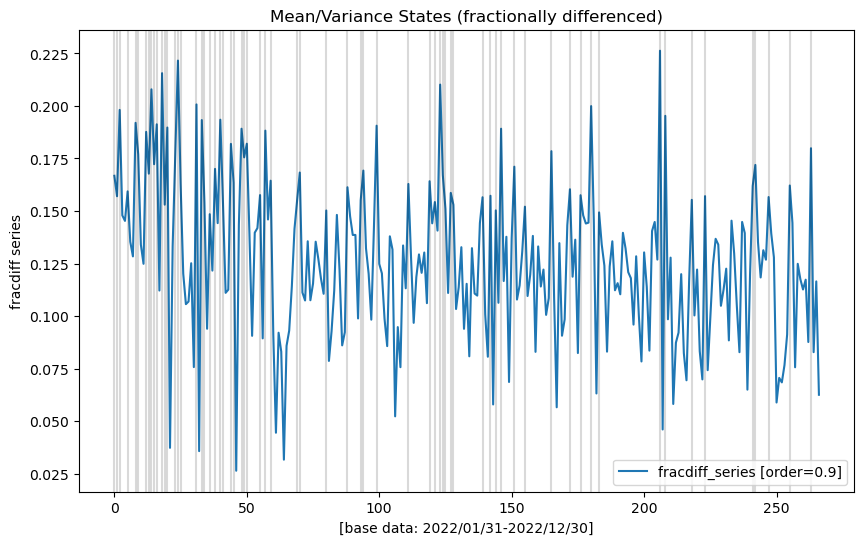

state_counts=
[ 0. 24.  0.  0. 67.  0. 97.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 79.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [168]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(x=frac_df.index, y=frac_df['data'], ax=ax, label=f'fracdiff_series [order={frac_order}]')

for M in range(len(states)): 
  if states[M] == states[0]:
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Mean/Variance States (fractionally differenced)')
ax.set_ylabel(f'fracdiff series')
ax.set_xlabel(f'[base data: 2022/01/31-2022/12/30]')
plt.show()

print('state_counts=')
print(state_counts)